# Count $<i,j>$ pairs as inputs to learn Node Embedding

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.io import loadmat
from random import choices
import copy
from scipy.sparse import issparse
from statistics import mean

## Find percolation threshold. Avarage size of largest cluster $<s_{max}>$ v.s. $\beta$

### 1. Transform edgelist to Graph

In [7]:
def load_matfile(file_, variable_name="network", unDirected=True, unWeighted = True):
    mat_variables = loadmat(file_)
    mat_matrix = mat_variables[variable_name]
    if issparse(mat_matrix):
        if unDirected:
            G = nx.Graph()
        else:
            G = nx.DiGraph()
            
        '''
        from_nodes: cx.row
        to_nodes: cx.col
        link weights: cx.data
        '''
        cx = mat_matrix.tocoo()
        if unWeighted:
            edge_list = np.array([cx.row, cx.col]).T
            G.add_edges_from(edge_list)
        else:
            edge_list = np.array([cx.row, cx.col, cx.data]).T
            G.add_weighted_edges_from(edge_list)

            
    return G

In [9]:
'''
"blogcatalog.mat" is a undirected, unweighted graph
# of nodes = 10312
# of edges = 333983
'''
# G = graph.load_matfile(args.input, variable_name=args.matfile_variable_name, undirected=args.undirected)
G_blogcatalog = load_matfile(file_ = "blogcatalog.mat")
print("# of nodes = ",G_blogcatalog.number_of_nodes())
print("# of edges = ",G_blogcatalog.number_of_edges())

# of nodes =  10312
# of edges =  333983


In [36]:
def percolate(G, beta = 0.005, unWeighted = True):
    edges_percolated = []
    if unWeighted:
        G_percolated = nx.Graph()
        G_percolated.add_nodes_from(list(G.nodes))
        numPercolatedEdges = int(beta*G.number_of_edges())
        edges_percolated = choices(list(G.edges), k=numPercolatedEdges)
        assert(len(edges_percolated) ==  numPercolatedEdges)
        G_percolated.add_edges_from(edges_percolated)
    return G_percolated

In [50]:
betas = np.linspace(0,0.5,10)
average_sizes_Gc = []
numIter = 100
for beta in betas:
    sizes_Gc = []
    for i in range(numIter):
        G_percolated = percolate(G_blogcatalog)
        # graphs = list(nx.connected_component_subgraphs(G))
        # largest percolated cluster
        Gc = max(nx.connected_component_subgraphs(G_percolated), key=len)
        sizes_Gc.append(Gc.number_of_edges())
    average_sizes_Gc.append(mean(sizes_Gc))

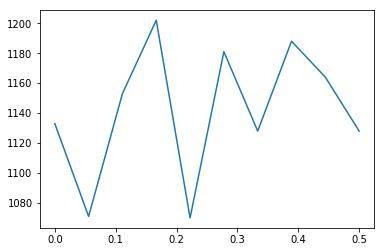

In [51]:
plt.plot(betas,sizes_Gc)